## CIFAR 10

In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22_cat, wrn_22, WideResNetConcat
torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=512
sz=32
workers=7

In [8]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def pad(img, p=4, padding_mode='reflect'):
    return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))

def torch_loader(data_path, size):
    if not os.path.exists(data_path+'/train'): download_cifar10(data_path)

    # Data loading code
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'test')
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    tfms = [transforms.ToTensor(), normalize]

    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(),
    ] + tfms)
    val_tfms = transforms.Compose(tfms)

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    val_dataset = datasets.ImageFolder(valdir, val_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs*2, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [9]:
data = torch_loader(str(PATH), sz)

In [10]:
m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)

In [8]:
# m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 3e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,.9), lr_decay=DecayType.COSINE, momentum=(0.95,0.85), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=4, lr=1, momentum=0.85),
    TrainingPhase(**def_phase, epochs=7, lr=(.9,.01), lr_decay=DecayType.COSINE, momentum=(0.85,0.95), momentum_decay=DecayType.COSINE),
    TrainingPhase(**def_phase, epochs=3, lr=(.01,.0005), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.761852   1.757055   0.3898    
    1      1.360327   1.520744   0.4945                   
    2      1.109995   1.216925   0.589                    
    3      0.969287   2.198741   0.4391                    
    4      0.867365   1.614184   0.5497                    
    5      0.791448   0.946364   0.6967                    
    6      0.714904   0.878727   0.7158                    
    7      0.692883   1.424522   0.6037                    
    8      0.648858   0.79865    0.7406                    
    9      0.60791    0.761378   0.756                     
    10     0.576517   0.767685   0.7483                    
    11     0.529468   0.769277   0.7641                    
    12     0.510787   0.837388   0.735                     
    13     0.479256   0.717998   0.7791                    
    14     0.449621   0.486753   0.8384                    
    15     0.390974   0.443203   0.8498                    

[array([0.33398]), 0.8880000001907349]

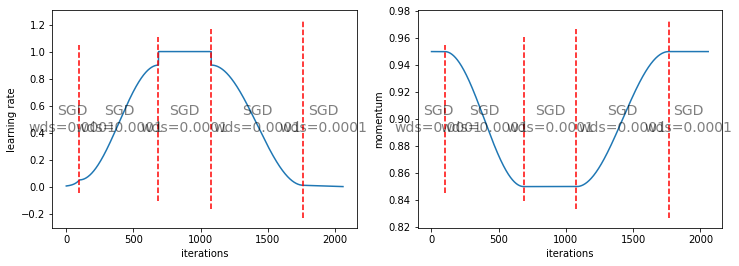

In [9]:
learn.sched.plot_lr()

In [32]:
m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=1.5
learn.clip = 3e-1
%time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(12,22,0.95,0.85), loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.806261   2.38502    0.2867    
 31%|███       | 30/98 [00:01<00:03, 17.21it/s, loss=1.73]

Exception in thread Thread-116:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



    1      1.587137   1.61741    0.4225                   
    2      1.367738   1.419003   0.4882                   
    3      1.19919    1.274403   0.5533                   
    4      1.073841   3.326963   0.3834                   
    5      0.9691     1.078952   0.6235                    
    6      0.905623   1.121126   0.6357                    
    7      0.841181   1.035561   0.6491                    
    8      0.779922   0.934859   0.7001                    
    9      0.737408   1.207841   0.6204                    
    10     0.684814   2.405613   0.4731                    
    11     0.6451     1.402425   0.6207                    
    12     0.609669   0.751729   0.7505                    
    13     0.573796   0.896227   0.7064                    
    14     0.533118   0.589232   0.8004                    
    15     0.505873   0.640289   0.79                      
    16     0.461451   0.575303   0.8015                    
    17     0.398086   0.415703   0.8597     

[array([0.34516]), 0.8851000004768371]

In [34]:
m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=1.2
learn.clip = 1e-1
%time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(12,22,0.95,0.85), loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.741394   1.759681   0.3866    
 26%|██▌       | 25/98 [00:01<00:04, 15.79it/s, loss=1.65]

Exception in thread Thread-204:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



    1      1.440413   1.37517    0.5214                   
    2      1.227353   1.674273   0.4851                   
    3      1.032488   1.294447   0.5843                   
    4      0.919178   1.009297   0.6475                    
    5      0.832561   1.063883   0.6714                    
    6      0.767719   0.760484   0.7413                    
    7      0.737036   1.145635   0.6604                    
    8      0.692389   0.927057   0.7032                    
    9      0.653754   0.743638   0.7582                    
    10     0.618667   1.252042   0.6416                    
    11     0.572368   0.747761   0.7565                    
    12     0.556893   0.801642   0.7438                    
    13     0.516589   0.747248   0.7647                    
    14     0.493264   0.734781   0.7615                    
    15     0.459561   0.634599   0.7933                    
    16     0.424271   0.443734   0.8502                    
    17     0.373193   0.415366   0.855     

[array([0.34102]), 0.8893999980926514]

In [23]:
m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-5
lr=1.5
learn.clip = 1e-1

def_phase = {'opt_fn':optim.SGD, 'wds':wd}
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.05,.3), lr_decay=DecayType.EXPONENTIAL, momentum=0.95)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.819172   2.652628   0.2322    



[array([2.65263]), 0.2321999998986721]

In [24]:
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(12,20,0.95,0.85), loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.620278   1.701273   0.3826    
    1      1.510005   1.538612   0.446                    
    2      1.361723   1.463483   0.4853                   
    3      1.21785    1.636317   0.4442                   
    4      1.07617    1.350984   0.5514                   
    5      0.94623    0.931734   0.6719                    
    6      0.880755   0.995998   0.6653                    
    7      0.813099   1.032262   0.6692                    
    8      0.753386   0.924827   0.6958                    
    9      0.710357   1.074462   0.6791                    
    10     0.680725   1.19892    0.6476                    
    11     0.642882   1.026539   0.6961                    
    12     0.586947   0.915834   0.6984                    
    13     0.567908   0.60309    0.7954                    
    14     0.537109   0.825827   0.7383                    
    15     0.507322   0.626826   0.7942                    
 

[array([0.36352]), 0.8841000004768371]

In [25]:
m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-5
lr=2
learn.clip = 1e-1

def_phase = {'opt_fn':optim.SGD, 'wds':wd}
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.05,.3), lr_decay=DecayType.EXPONENTIAL, momentum=0.95)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(12,20,0.95,0.85), loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.845233   2.802534   0.2735    



epoch      trn_loss   val_loss   accuracy                 
    0      1.633904   2.710247   0.2791    
    1      1.486299   3.49182    0.3028                   
    2      1.328809   1.587332   0.4842                   
    3      1.210989   5.672656   0.194                    
    4      1.121563   1.559684   0.5344                   
    5      1.018739   1.152225   0.6128                   
    6      0.939021   1.682416   0.5204                    
    7      0.871501   1.179796   0.6096                    
    8      0.839508   1.168657   0.6233                    
    9      0.787797   0.988534   0.6923                    
    10     0.723172   1.014931   0.6868                    
    11     0.693786   1.480969   0.5974                    
    12     0.665684   1.6327     0.6105                    
    13     0.609589   0.69722    0.7687                    
    14     0.575822   0.718229   0.7739                    
    15     0.545219   0.758094   0.756                     
  

Process Process-877:
Process Process-882:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Process Process-876:
Process Process-878:
Process Process-881:
Traceback (most recent call last):
Process Process-880:
Process Process-879:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):


Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1230, in time
    out = eval(code, glob, local_ns)
  File "<timed eval>", line 1, in <module>
  File "/home/paperspace/fastai/courses/dl2/fastai/learner.py", line 287, in fit
    return self.fit_gen(self.model, self.data, layer_opt, n_cycle, **kwargs)
  File "/home/paperspace/fastai/courses/dl2/fastai/learner.py", line 234, in fit_gen
    swa_eval_freq=swa_eval_freq, **kwargs)
  File "/home/paperspace/fastai/courses/dl2/fastai/model.py", line 150, in fit
    vals = validate(model_stepper, cur_data.val_dl, metrics)
  File "/home/paperspace/fastai/courses/dl2/fastai/model.py", line 207, in validate
    preds, l = stepper.evaluate(VV(x), VV(y))
  File "/home/paperspace/fastai/courses/dl2/fastai/model.py", line 68, in evaluate
    preds = self.m(*xs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/m

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
Exception in thread Thread-208:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 68, in _worker_manager_loop
    r = in_queue.get()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  Fil

KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py

  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/ImageFile.py", line 236, in load
    n, err_code = decoder.decode(b)
KeyboardInterrupt
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 135, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/tensor.py", line 53, in float
    return self.type(type(self).__module__ + '.FloatTensor')
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 112, in default_collate
    return torch.stack(batch, 0, out=out)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/functional.py", line 66, in stack
    return torch.cat(inputs, dim, out=out)
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/_utils.py", line 24, in _type
    new_type = _im

In [27]:
m

WideResNetConcat(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BasicBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        (1): ReLU(inplace)
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (2): BasicBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        (1): ReLU(inplace)
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (3): BasicBlock(
      (bn): BatchNorm2d(16, eps=1e-05

In [28]:
m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-5
lr=1.2
learn.clip = 1e-1

def_phase = {'opt_fn':optim.SGD, 'wds':wd}
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.05,.3), lr_decay=DecayType.EXPONENTIAL, momentum=0.95)]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)
%time learn.fit(lr, 1, wds=wd, cycle_len=30, use_clr_beta=(12,20,0.95,0.85), loss_scale=512)

 93%|█████████▎| 91/98 [00:03<00:00, 22.99it/s, loss=1.89]


Exception in thread Thread-151:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy   
    0      1.876401   4.243016   0.2015    



epoch      trn_loss   val_loss   accuracy                 
    0      1.572344   1.598391   0.4289    
    1      1.440009   1.441077   0.4774                   
    2      1.265053   2.137303   0.4567                   
    3      1.108983   1.048392   0.6362                   
    4      1.002449   1.548284   0.5237                   
    5      0.905223   1.946484   0.454                     
    6      0.829811   1.241036   0.6173                    
    7      0.768609   0.900597   0.702                     
    8      0.706589   0.882741   0.7152                    
    9      0.658353   0.90341    0.7081                    
    10     0.638974   0.934314   0.7082                    
    11     0.609519   0.611615   0.7933                    
    12     0.568181   0.67357    0.7729                    
    13     0.542845   0.711248   0.7643                    
    14     0.521269   0.577272   0.8031                    
    15     0.485321   0.734381   0.7663                    
 

[array([0.35918]), 0.8855999978065491]